In [1]:
import os
import json
import time
import numpy as np
import pandas as pd
import torch
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from fastai.vision.all import *
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances


In [2]:
# --- Parameter ---
TEST_JSON_PATH = "../train_test_split_new.json"
BASE_PATH = "../basemodel_outputs"
MODEL_PATHS = [
    f"{BASE_PATH}/ViT_bs64+augm+iNat.pkl",
    f"{BASE_PATH}/googlenet_bs128+aug.pkl",
    f"{BASE_PATH}/resnet50_bs16+aug+iNat.pkl"
]

DISTANCE_METRICS = ["euclidean", "manhattan", "cosine", "faiss_euclidean", "faiss_cosine"]

# --- 1. Testdaten laden ---
with open(TEST_JSON_PATH, "r") as f:
    split = json.load(f)

df_test = pd.DataFrame(split["test"])
df_test['file_path'] = df_test['file_path'].apply(lambda x: os.path.join("..", "balanced_dataset_split", "balanced_dataset_split", x))

df_test.head()

file_path  \
0  ../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0221.JPG   
1  ../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0230.JPG   
2  ../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0231.JPG   
3  ../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0233.JPG   
4  ../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0234.JPG   

              label  
0  acinonyx jubatus  
1  acinonyx jubatus  
2  acinonyx jubatus  
3  acinonyx jubatus  
4  acinonyx jubatus

## Qualitative Evaluation

In [3]:
# --- 2. Feature-Extraktion ---
def extract_features(learn, img_path):
    img = PILImage.create(img_path)
    img = learn.dls.test_dl([img]).one_batch()[0]
    device = next(learn.model.parameters()).device
    img = img.to(device)
    with torch.no_grad():
        feats = learn.model(img)
    if feats.ndim == 4:
        feats = torch.nn.functional.adaptive_avg_pool2d(feats, (1, 1)).squeeze()
    elif feats.ndim == 3:
        feats = feats.mean(dim=(-1, -2))
    if feats.ndim == 2:
        feats = feats.squeeze(0)
    return feats.cpu().numpy()

# --- 3. Suche ---
def search(query_feat, database_feats, metric="euclidean", top_k=5):
    if metric == "cosine":
        sims = cosine_similarity([query_feat], database_feats)[0]
        top_indices = np.argsort(sims)[::-1][:top_k]
    elif metric == "euclidean":
        dists = euclidean_distances([query_feat], database_feats)[0]
        top_indices = np.argsort(dists)[:top_k]
    elif metric == "manhattan":
        dists = manhattan_distances([query_feat], database_feats)[0]
        top_indices = np.argsort(dists)[:top_k]
    elif metric == "faiss_euclidean":
        dim = database_feats.shape[1]
        index = faiss.IndexFlatL2(dim)
        index.add(database_feats.astype(np.float32))
        _, top_indices = index.search(np.expand_dims(query_feat.astype(np.float32), axis=0), top_k)
        top_indices = top_indices[0]
    elif metric == "faiss_cosine":
        database_feats = database_feats / np.linalg.norm(database_feats, axis=1, keepdims=True)
        query_feat = query_feat / np.linalg.norm(query_feat)
        dim = database_feats.shape[1]
        index = faiss.IndexFlatIP(dim)
        index.add(database_feats.astype(np.float32))
        _, top_indices = index.search(np.expand_dims(query_feat.astype(np.float32), axis=0), top_k)
        top_indices = top_indices[0]
    else:
        raise ValueError("Unknown metric")
    return top_indices


In [4]:
# --- 4. Metriken ---
def precision_at_k(query_label, retrieved_labels, k):
    correct = sum([1 for label in retrieved_labels[:k] if label == query_label])
    return correct / k

def average_precision(query_label, retrieved_labels):
    relevant = [1 if label == query_label else 0 for label in retrieved_labels]
    if sum(relevant) == 0:
        return 0
    precisions = [precision_at_k(query_label, retrieved_labels, k+1) for k in range(len(relevant)) if relevant[k]]
    return np.mean(precisions)


In [ ]:
# --- 5. CBIR Evaluation ---
all_results = []

for model_path in MODEL_PATHS:
    model_name = os.path.basename(model_path).replace(".pkl", "")
    print(f"\n\n🔍 Testing CBIR mit Modell: {model_name}")

    learn = load_learner(model_path)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    learn.model = learn.model.to(device)

    # Features extrahieren
    features_list, labels_list = [], []

    for img_path in df_test['file_path']:
        feats = extract_features(learn, img_path)
        label = os.path.basename(os.path.dirname(img_path))
        features_list.append(feats)
        labels_list.append(label)

    features_array = np.stack(features_list)
    labels_array = np.array(labels_list)

    # Features speichern
    feature_save_path = f"features_{model_name}.npz"
    np.savez(feature_save_path, features=features_array, labels=labels_array)

    for metric in DISTANCE_METRICS:
        print(f"\n➡️  Teste mit Distanz-Metrik: {metric}")

        precisions, aps, top1_accs, recalls, times = [], [], [], [], []

        for idx, query_feat in enumerate(features_array):
            query_label = labels_array[idx]

            start = time.time()
            top_indices = search(query_feat, features_array, metric=metric, top_k=6)
            elapsed = time.time() - start
            times.append(elapsed)

            top_indices = top_indices[1:]  
            retrieved_labels = labels_array[top_indices]

            precisions.append(precision_at_k(query_label, retrieved_labels, k=5))
            aps.append(average_precision(query_label, retrieved_labels))
            top1_accs.append(1 if retrieved_labels[0] == query_label else 0)

            relevant_total = np.sum(labels_array == query_label) - 1
            relevant_retrieved = sum([1 for label in retrieved_labels[:5] if label == query_label])
            recall = relevant_retrieved / relevant_total if relevant_total > 0 else 0
            recalls.append(recall)

        mean_precision = np.mean(precisions)
        mean_ap = np.mean(aps)
        mean_top1 = np.mean(top1_accs)
        mean_recall = np.mean(recalls)
        mean_time = np.mean(times)

        print(f"✅ Precision@5: {mean_precision:.4f} | mAP: {mean_ap:.4f} | Top-1 Acc: {mean_top1:.4f} | Recall@5: {mean_recall:.4f} | ⏱ Avg Time: {mean_time:.4f}s")

        all_results.append({
            "Model": model_name,
            "Distance Metric": metric,
            "Precision@5": mean_precision,
            "mAP": mean_ap,
            "Top-1 Accuracy": mean_top1,
            "Recall@5": mean_recall,
            "Avg Search Time (s)": mean_time
        })

        # Detaillierte Ergebnisse pro Query speichern
        detail_path = f"cbir_detailed_{model_name}_{metric}.csv"
        df_detail = pd.DataFrame({
            "Path": df_test["file_path"].tolist(),  
            "Precision@5": precisions,
            "AP": aps,
            "Top-1 Accuracy": top1_accs,
            "Recall@5": recalls,
            "Search Time (s)": times,
            "Query Label": labels_array
        })
        #df_detail.to_csv(detail_path, index=False)

# --- 6. Alle Ergebnisse speichern ---
df_results = pd.DataFrame(all_results)
print("\n\n📈 Vergleich der CBIR-Modelle und Distanzen:")
print(df_results)



🔍 Testing CBIR mit Modell: ViT_bs64+augm+iNat

➡️  Teste mit Distanz-Metrik: euclidean
✅ Precision@5: 0.8541 | mAP: 0.9020 | Top-1 Acc: 0.8890 | Recall@5: 0.0747 | ⏱ Avg Time: 0.0003s

➡️  Teste mit Distanz-Metrik: manhattan
✅ Precision@5: 0.8331 | mAP: 0.8925 | Top-1 Acc: 0.8790 | Recall@5: 0.0707 | ⏱ Avg Time: 0.0003s

➡️  Teste mit Distanz-Metrik: cosine
✅ Precision@5: 0.8650 | mAP: 0.9074 | Top-1 Acc: 0.8955 | Recall@5: 0.0763 | ⏱ Avg Time: 0.0004s

➡️  Teste mit Distanz-Metrik: faiss_euclidean
✅ Precision@5: 0.8541 | mAP: 0.9020 | Top-1 Acc: 0.8890 | Recall@5: 0.0747 | ⏱ Avg Time: 0.0001s

➡️  Teste mit Distanz-Metrik: faiss_cosine
✅ Precision@5: 0.8650 | mAP: 0.9074 | Top-1 Acc: 0.8955 | Recall@5: 0.0763 | ⏱ Avg Time: 0.0002s


🔍 Testing CBIR mit Modell: googlenet_bs128+aug

➡️  Teste mit Distanz-Metrik: euclidean
✅ Precision@5: 0.6959 | mAP: 0.7934 | Top-1 Acc: 0.7639 | Recall@5: 0.0567 | ⏱ Avg Time: 0.0003s

➡️  Teste mit Distanz-Metrik: manhattan
✅ Precision@5: 0.6610 | mAP:

In [10]:
df_results.to_csv("CBIR_Ergebnisse.csv", index=False)

In [6]:
df_results = pd.read_csv("CBIR_Ergebnisse.csv")

df_results.head()

Model  Distance Metric  Precision@5       mAP  \
0  basemodel_ViT_bs64+augm+iNat        euclidean     0.854144  0.902001   
1  basemodel_ViT_bs64+augm+iNat        manhattan     0.833149  0.892462   
2  basemodel_ViT_bs64+augm+iNat           cosine     0.864992  0.907392   
3  basemodel_ViT_bs64+augm+iNat  faiss_euclidean     0.854144  0.902001   
4  basemodel_ViT_bs64+augm+iNat     faiss_cosine     0.864992  0.907392   

   Top-1 Accuracy  Recall@5  Avg Search Time (s)  
0        0.889001  0.074743             0.000341  
1        0.878955  0.070706             0.000261  
2        0.895530  0.076304             0.000356  
3        0.889001  0.074743             0.000071  
4        0.895530  0.076304             0.000161

In [ ]:
sns.set(style="whitegrid")

# --- 1. Alle detaillierten Ergebnisse laden ---
detail_files = glob.glob("cbir_detailed_*.csv")
results = []

for file in detail_files:
    base = os.path.basename(file).replace(".csv", "")
    parts = base.split("_")
    model = parts[2]
    metric = "_".join(parts[4:])
    
    df = pd.read_csv(file)
    df["Model"] = model
    df["Metric"] = metric
    results.append(df)

# Falls keine Dateien gefunden wurden
if not results:
    raise ValueError("Keine Dateien im Format 'cbir_detailed_*.csv' gefunden. Bitte überprüfen!")

# Alle Daten in ein gemeinsames DataFrame
df_all = pd.concat(results, ignore_index=True)

# Klassifizierung der Metrik-Typen: Klassisch vs FAISS
df_all["Metric Type"] = df_all["Metric"].apply(lambda x: "FAISS" if "faiss" in x else "Classical")

df_all.head()


Path  \
0  ../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0221.JPG   
1  ../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0230.JPG   
2  ../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0231.JPG   
3  ../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0233.JPG   
4  ../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0234.JPG   

   Precision@5        AP  Top-1 Accuracy  Recall@5  Search Time (s)  \
0          0.6  0.916667               1  0.034483         0.000412   
1          0.4  0.500000               0  0.022989         0.000299   
2          0.6  0.916667               1  0.034483         0.000286   
3          1.0  1.000000               1  0.057471         0.000281   
4          0.8  0.887500               1  0.045977         0.000277   

        Query Label Model     Metric Metric Type  
0  acinonyx jubatus   ViT  manhattan   Classical  
1  acinonyx jubatus   ViT  manhattan   Classical  
2  acinonyx jubatus   ViT  manhattan   Classical  
3  acinonyx jubatus   ViT  manhattan   Classical  
4  acinonyx jubatus   ViT  manhattan   Classical

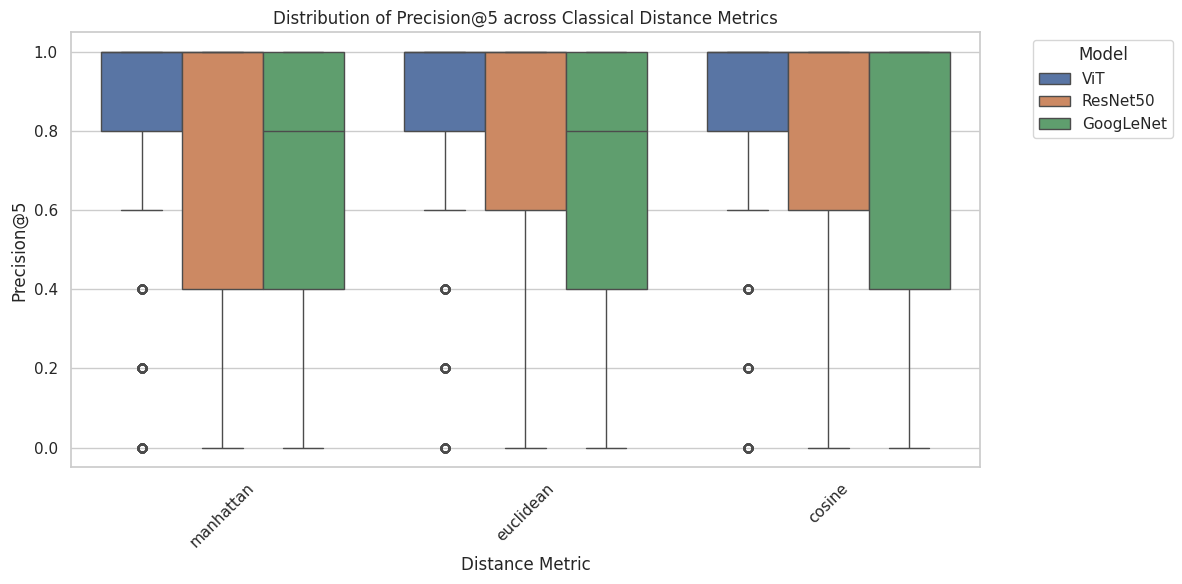

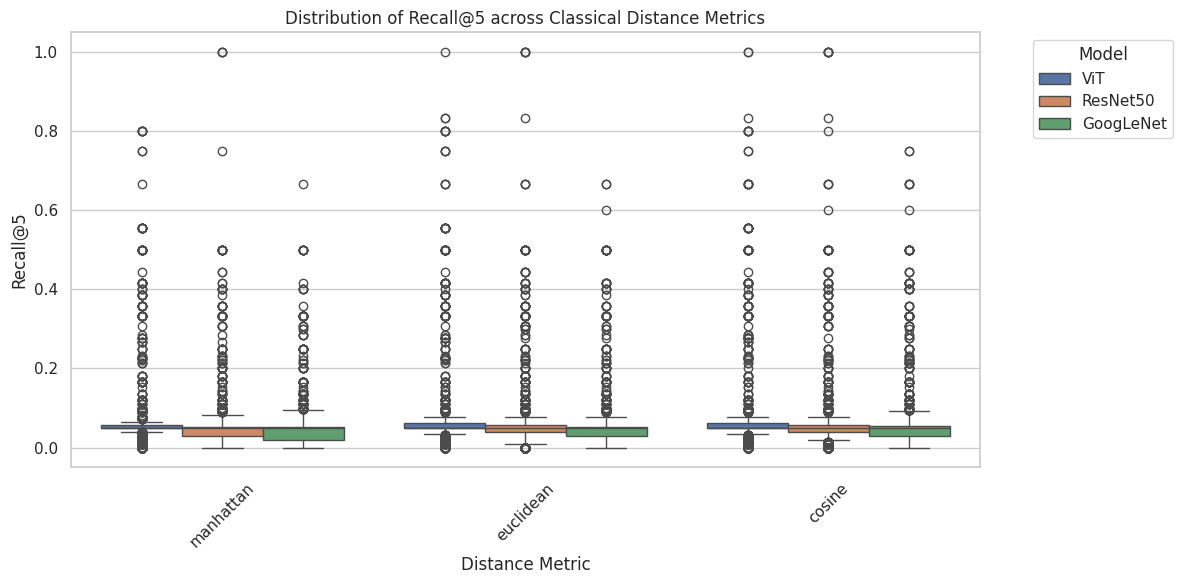

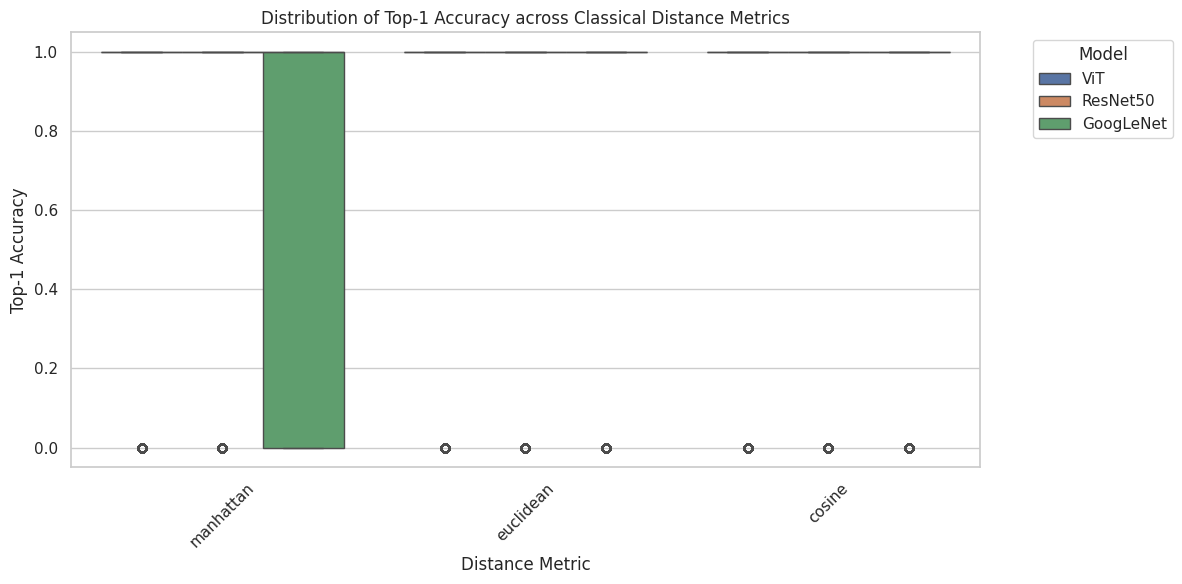

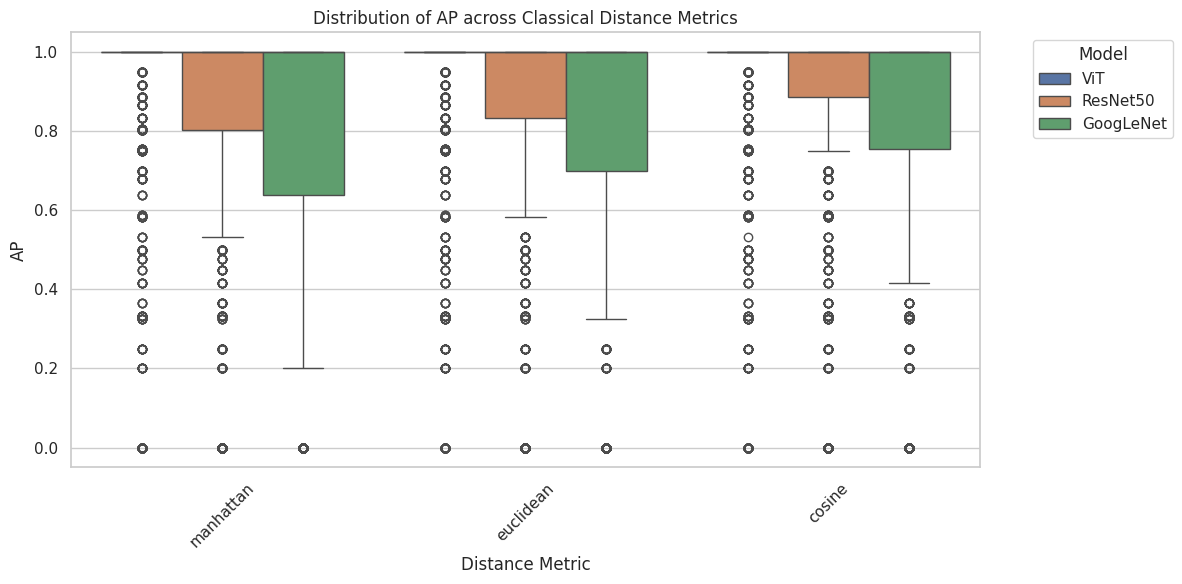

In [ ]:
# Filtere nur klassische Metriken im df_all
classic_metrics = ["cosine", "euclidean", "manhattan"]
df_all_classic = df_all[df_all["Metric"].isin(classic_metrics)]


for metric in ["Precision@5", "Recall@5", "Top-1 Accuracy", "AP"]:
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=df_all_classic,
        x="Metric",
        y=metric,
        hue="Model",
        #palette=palette_dict  
    )
    plt.title(f"Distribution of {metric} across Classical Distance Metrics")
    plt.ylabel(metric)
    plt.xlabel("Distance Metric")
    plt.xticks(rotation=45)
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"boxplot_{metric}_classical.pdf", dpi=300, bbox_inches='tight')
    plt.show()


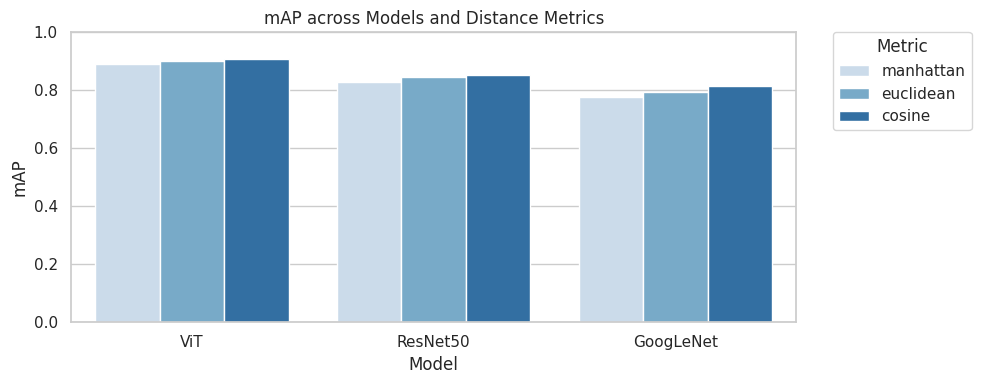

In [32]:

plt.figure(figsize=(10, 4))
sns.barplot(
    data=df_all_classic[df_all_classic["Metric"].isin(["cosine", "euclidean", "manhattan"])],
    x="Model", y="AP", hue="Metric", palette="Blues", errorbar=None
)

plt.title("mAP across Models and Distance Metrics")
plt.ylabel("mAP")
plt.ylim(0, 1)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.savefig("map_barplot_models_metrics_classic.pdf", dpi=300, bbox_inches='tight')
plt.show()


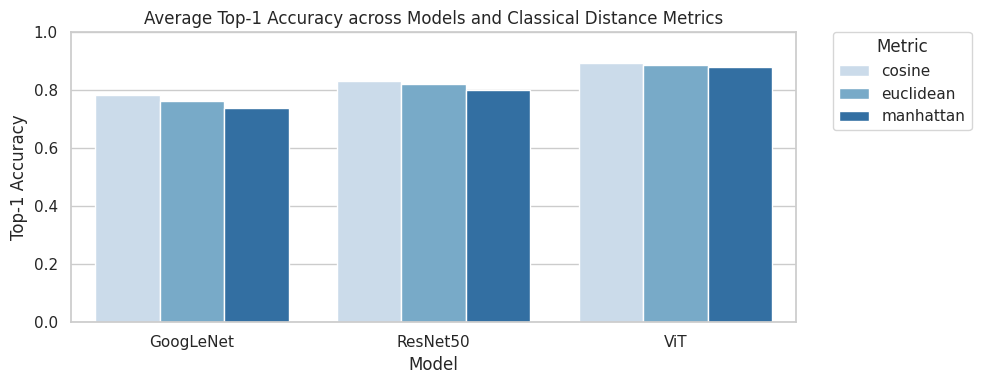

In [33]:
# Klassische Metriken auswählen
classic_metrics = ["cosine", "euclidean", "manhattan"]
df_recall = df_all[df_all["Metric"].isin(classic_metrics)]

# Mittelwerte berechnen
df_recall_grouped = df_recall.groupby(["Model", "Metric"])["Top-1 Accuracy"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 4))
barplot = sns.barplot(
    data=df_recall_grouped,
    x="Model",
    y="Top-1 Accuracy",
    hue="Metric",
    palette="Blues"
)

plt.title("Average Top-1 Accuracy across Models and Classical Distance Metrics")
plt.ylabel("Top-1 Accuracy")
plt.ylim(0, 1)

# Legende außerhalb platzieren
plt.legend(
    title="Metric",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

plt.tight_layout()
plt.savefig("top1accuracy_barplot_classic.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Klassische Metriken auswählen
classic_metrics = ["cosine", "euclidean", "manhattan"]
df_top1 = df_all[df_all["Metric"].isin(classic_metrics)]

# Mittelwerte berechnen
df_grouped_top1 = df_top1.groupby(["Model", "Metric"])["Top-1 Accuracy"].mean().reset_index()

# Ausgeben der Werte nach Modell gruppiert
for model in df_grouped_top1["Model"].unique():
    print(f"\n{model}:")
    df_model = df_grouped_top1[df_grouped_top1["Model"] == model]
    for _, row in df_model.iterrows():
        print(f"  {row['Metric']}: Top-1 Accuracy = {row['Top-1 Accuracy']:.4f}")



ViT:
  cosine: Top-1 Accuracy = 0.8955
  euclidean: Top-1 Accuracy = 0.8890
  manhattan: Top-1 Accuracy = 0.8790

googlenet:
  cosine: Top-1 Accuracy = 0.7850
  euclidean: Top-1 Accuracy = 0.7639
  manhattan: Top-1 Accuracy = 0.7388

resnet50:
  cosine: Top-1 Accuracy = 0.8307
  euclidean: Top-1 Accuracy = 0.8207
  manhattan: Top-1 Accuracy = 0.8016


In [27]:
# Nur klassische Metriken berücksichtigen
classic_metrics = ["cosine", "euclidean", "manhattan"]

# Mittelwerte berechnen (mAP je Modell und Metrik)
df_map = df_all[df_all["Metric"].isin(classic_metrics)]
df_grouped_map = df_map.groupby(["Model", "Metric"])["AP"].mean().reset_index()

# Nach Modell gruppiert ausgeben
for model in df_grouped_map["Model"].unique():
    print(f"\n{model}:")
    df_model = df_grouped_map[df_grouped_map["Model"] == model]
    for _, row in df_model.iterrows():
        print(f"  {row['Metric']}: mAP = {row['AP']:.4f}")



ViT:
  cosine: mAP = 0.9074
  euclidean: mAP = 0.9020
  manhattan: mAP = 0.8925

googlenet:
  cosine: mAP = 0.8143
  euclidean: mAP = 0.7934
  manhattan: mAP = 0.7776

resnet50:
  cosine: mAP = 0.8527
  euclidean: mAP = 0.8445
  manhattan: mAP = 0.8274


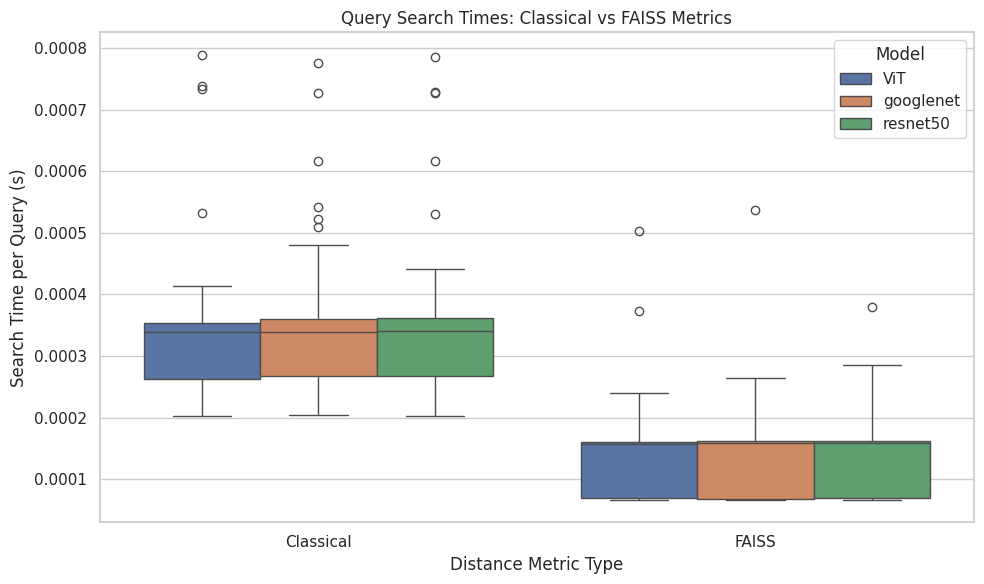

In [ ]:
#  Vergleich der Suchzeiten: Klassisch vs FAISS

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x="Metric Type", y="Search Time (s)", hue="Model")
plt.title("Query Search Times: Classical vs FAISS Metrics")
plt.ylabel("Search Time per Query (s)")
plt.xlabel("Distance Metric Type")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

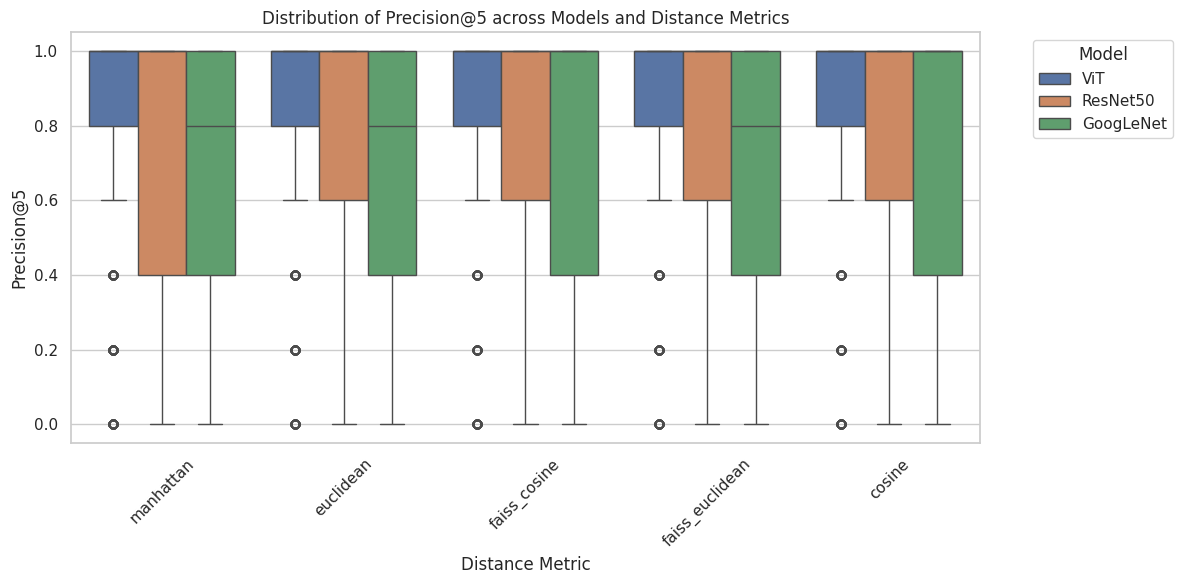

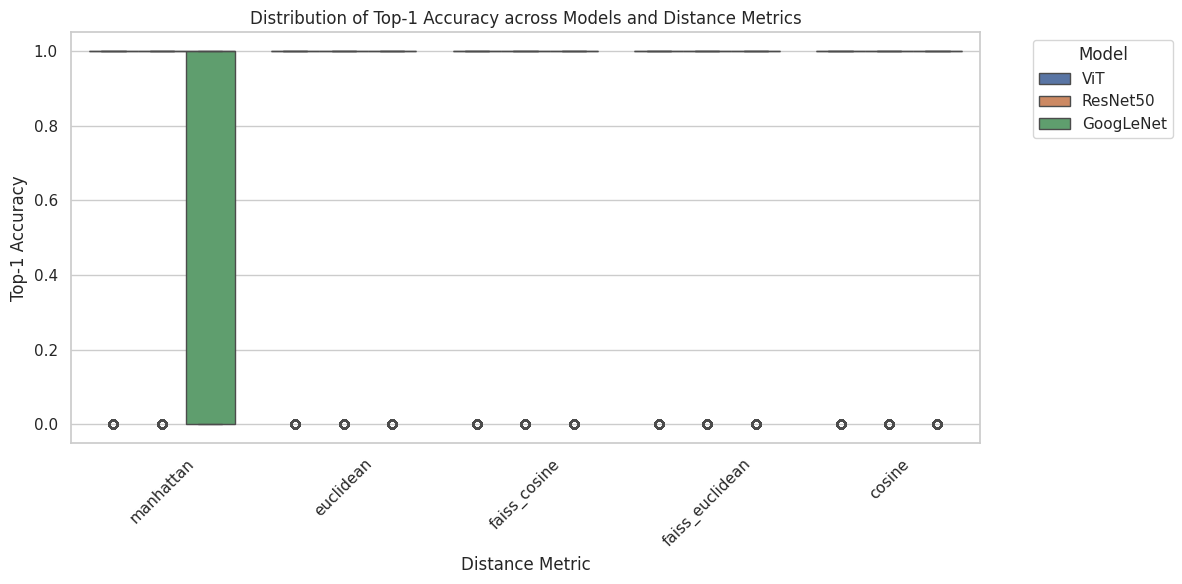

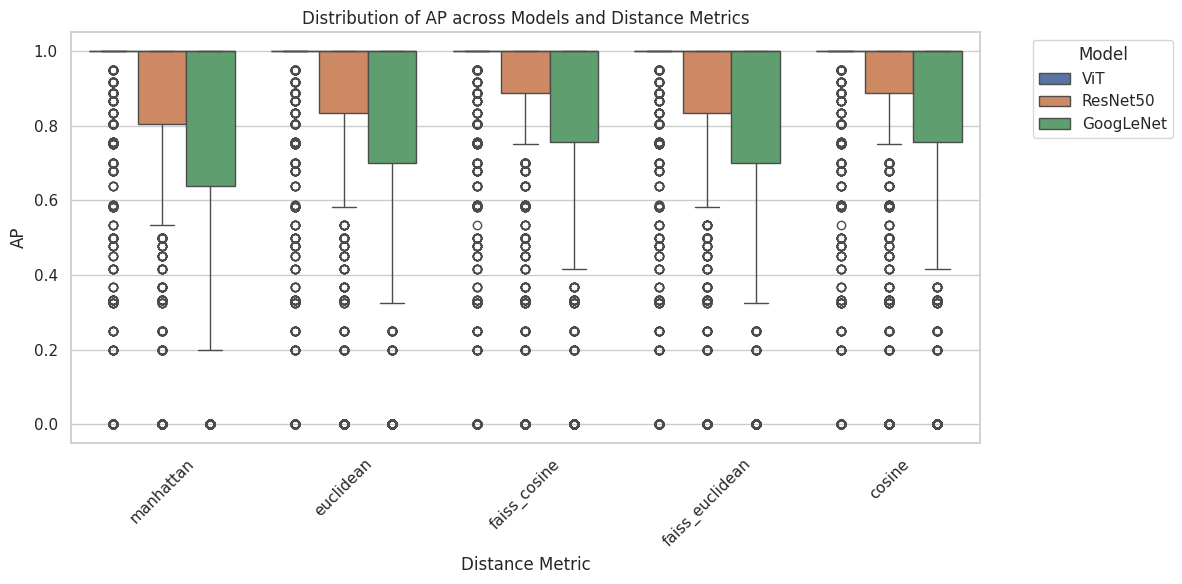

In [ ]:
# Farben aus Blues-Palette auswählen
full_palette = sns.color_palette("Blues", n_colors=9)
selected_colors = [full_palette[i] for i in [2, 5, 8]]  # Anpassen je nach Anzahl Modelle

# Modelle abrufen und Farben zuweisen
model_order = df_map["Model"].unique()
#palette_dict = {model: color for model, color in zip(model_order, selected_colors)}

# Boxplots
for metric in ["Precision@5", "Top-1 Accuracy", "AP"]:
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=df_all,
        x="Metric",
        y=metric,
        hue="Model",
        #palette=palette_dict
    )
    plt.title(f"Distribution of {metric} across Models and Distance Metrics")
    plt.ylabel(metric)
    plt.xlabel("Distance Metric")
    plt.xticks(rotation=45)
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"boxplot_{metric}_blues.pdf", dpi=300, bbox_inches='tight')
    plt.show()


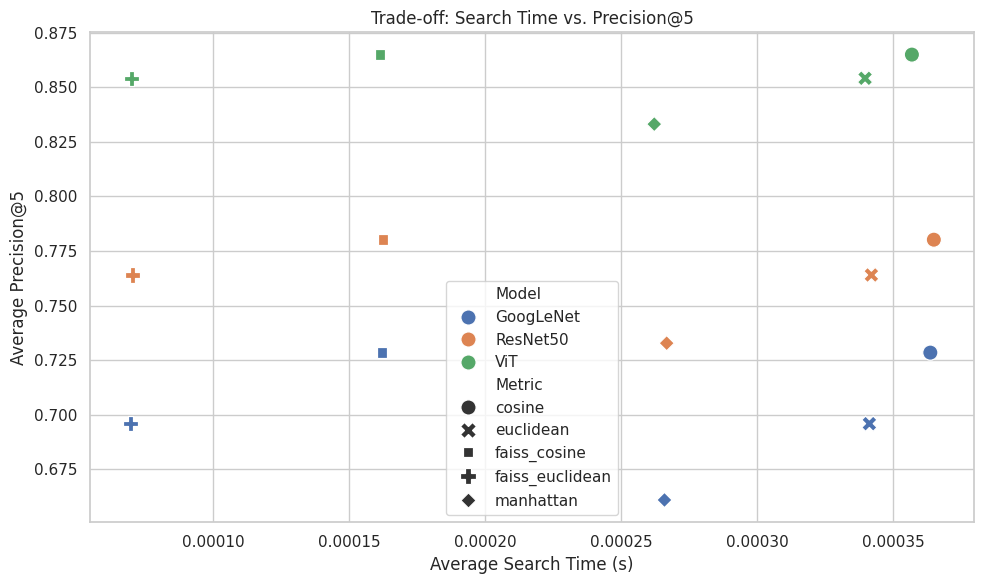

In [ ]:
# Trade-off: Suchzeit vs. Precision@5 (Durchschnittswerte)

df_tradeoff = df_all.groupby(["Model", "Metric"]).agg({
    "Precision@5": "mean",
    "Search Time (s)": "mean"
}).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_tradeoff,
    x="Search Time (s)",
    y="Precision@5",
    hue="Model",
    style="Metric",
    s=120
)
plt.title("Trade-off: Search Time vs. Precision@5")
plt.xlabel("Average Search Time (s)")
plt.ylabel("Average Precision@5")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
full_palette = sns.color_palette("Blues", n_colors=9)

selected_colors = [full_palette[i] for i in [2, 5, 8]]

# Map Modelle auf feste Farben (Reihenfolge muss zu df_tradeoff["Model"].unique() passen)
model_order = df_tradeoff["Model"].unique()
palette_dict = {model: color for model, color in zip(model_order, selected_colors)}

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df_tradeoff,
    x="Search Time (s)",
    y="AP",
    hue="Model",
    style="Metric",
    palette=palette_dict,
    s=120
)

plt.title("Trade-off: Search Time vs. mAP")
plt.xlabel("Average Search Time (s)")
plt.ylabel("mAP")
plt.grid(True)

# Punktbeschriftung
for _, row in df_tradeoff.iterrows():
    plt.text(
        row["Search Time (s)"] + 0.00001,
        row["AP"],
        f"{row['AP']:.3f}",
        fontsize=9,
        va='center'
    )

# Legende außerhalb
plt.legend(
    title="Model / Metric",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

plt.tight_layout()
plt.savefig("tradeoff_mAP_vs_SearchTime_labeled.png", dpi=300, bbox_inches='tight')
plt.show()

## Query Result Visualization

 Darstellung der Query + Top-K Ergebnisse

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import os

In [11]:
df_results = pd.read_csv('CBIR_Ergebnisse.csv')

df_results.head()

Model  Distance Metric  Precision@5       mAP  \
0  basemodel_ViT_bs64+augm+iNat        euclidean     0.854144  0.902001   
1  basemodel_ViT_bs64+augm+iNat        manhattan     0.833149  0.892462   
2  basemodel_ViT_bs64+augm+iNat           cosine     0.864992  0.907392   
3  basemodel_ViT_bs64+augm+iNat  faiss_euclidean     0.854144  0.902001   
4  basemodel_ViT_bs64+augm+iNat     faiss_cosine     0.864992  0.907392   

   Top-1 Accuracy  Recall@5  Avg Search Time (s)  
0        0.889001  0.074743             0.000341  
1        0.878955  0.070706             0.000261  
2        0.895530  0.076304             0.000356  
3        0.889001  0.074743             0.000071  
4        0.895530  0.076304             0.000161

In [12]:
def load_model_outputs():
    model_outputs = {}
    file_map = {
        "ViT": "features_ViT_bs64+augm+iNat.npz",
        "ResNet50": "features_resnet50_bs16+aug+iNat.npz",
        "GoogLeNet": "features_googlenet_bs128+aug.npz"
    }

    for model_name, filename in file_map.items():
        if os.path.exists(filename):
            data = np.load(filename)
            model_outputs[model_name] = {
                "features": data["features"],
                "labels": data["labels"]
            }
        else:
            print(f"⚠️ Datei nicht gefunden: {filename}")
    
    return model_outputs

model_outputs = load_model_outputs()

In [13]:
def search(query_feat, database_feats, metric="euclidean", top_k=5):
    if metric == "cosine":
        sims = cosine_similarity([query_feat], database_feats)[0]
        top_indices = np.argsort(sims)[::-1][:top_k]
        scores = sims[top_indices]
    elif metric == "euclidean":
        dists = euclidean_distances([query_feat], database_feats)[0]
        top_indices = np.argsort(dists)[:top_k]
        scores = dists[top_indices]
    elif metric == "manhattan":
        dists = manhattan_distances([query_feat], database_feats)[0]
        top_indices = np.argsort(dists)[:top_k]
        scores = dists[top_indices]
    # FAISS entsprechend anpassen falls nötig ...
    else:
        raise ValueError("Unknown metric")
    
    return top_indices, scores

In [16]:
# --- Metriken ---
def precision_at_k(query_label, retrieved_labels, k):
    correct = sum([1 for label in retrieved_labels[:k] if label == query_label])
    return correct / k

def average_precision(query_label, retrieved_labels):
    relevant = [1 if label == query_label else 0 for label in retrieved_labels]
    if sum(relevant) == 0:
        return 0
    precisions = [precision_at_k(query_label, retrieved_labels, k+1) for k in range(len(relevant)) if relevant[k]]
    return np.mean(precisions)


In [17]:
def visualize_query_results_with_scores(query_idx, model_name, metric_name, df_test, model_outputs, top_k=5):
    """
    Zeigt Query + Top-K Ergebnisse mit Bewertung und Scorewerten, automatisch je nach gewähltem Modell.
    """
    features_array = model_outputs[model_name]["features"]
    labels_array = model_outputs[model_name]["labels"]

    query_path = df_test.iloc[query_idx]['file_path']
    query_feat = features_array[query_idx]
    query_label = labels_array[query_idx]

    top_indices, scores = search(query_feat, features_array, metric=metric_name, top_k=top_k + 1)
    top_indices = top_indices[1:]
    scores = scores[1:]
    retrieved_labels = labels_array[top_indices]

    # Metriken berechnen
    precision_k = precision_at_k(query_label, retrieved_labels, k=top_k)
    recall_k = sum([1 for label in retrieved_labels if label == query_label]) / sum(labels_array == query_label)
    ap = average_precision(query_label, retrieved_labels)
    top1_acc = 1 if retrieved_labels[0] == query_label else 0

    # Plot
    fig, axes = plt.subplots(1, top_k + 1, figsize=(18, 4))
    axes[0].imshow(Image.open(query_path))
    axes[0].set_title("Query\n" + query_label, fontsize=10)
    axes[0].axis('off')

    for i, (idx, score) in enumerate(zip(top_indices, scores)):
        img_path = df_test.iloc[idx]['file_path']
        label = labels_array[idx]
        correct = (label == query_label)
        color = 'green' if correct else 'red'
        metric_label = f"{'Sim' if metric_name == 'cosine' else 'Dist'}: {score:.3f}"

        axes[i+1].imshow(Image.open(img_path))
        axes[i+1].set_title(f"Rank {i+1}\n{label}\n{metric_label}", fontsize=9, color=color)
        axes[i+1].axis('off')

    plt.suptitle(
        f"Model: {model_name} | Metric: {metric_name}\n"
        f"P@{top_k}: {precision_k:.3f} | R@{top_k}: {recall_k:.3f} | AP: {ap:.3f} | Top-1 Acc: {top1_acc}",
        fontsize=12
    )
    plt.tight_layout()
    plt.show()


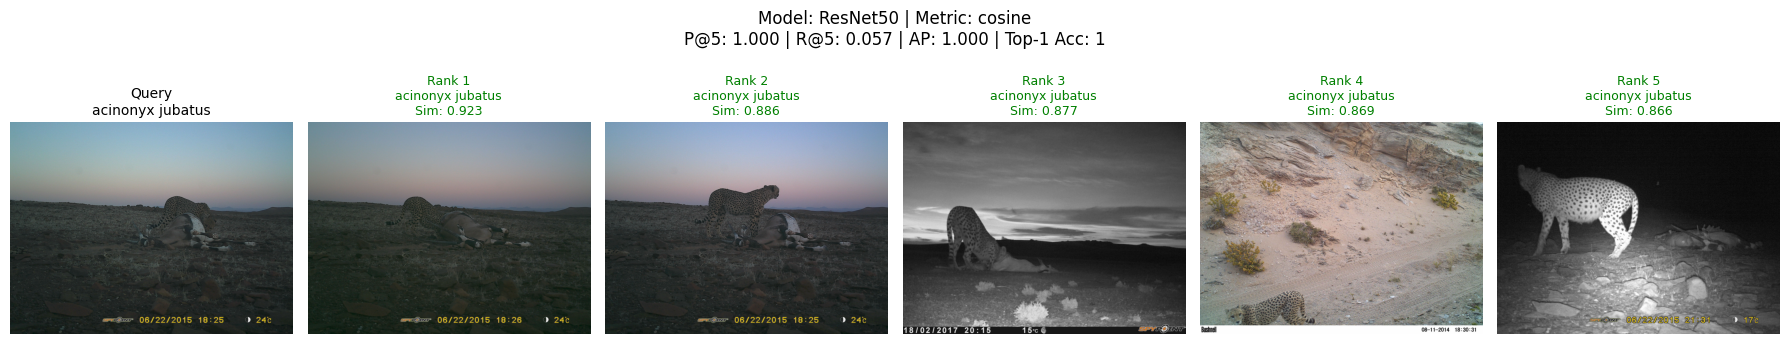

In [18]:
visualize_query_results_with_scores(
    query_idx=25,
    model_name="ResNet50",  # oder "ViT", "GoogLeNet"
    metric_name="cosine",
    df_test=df_test,
    model_outputs=model_outputs,
    top_k=5
)

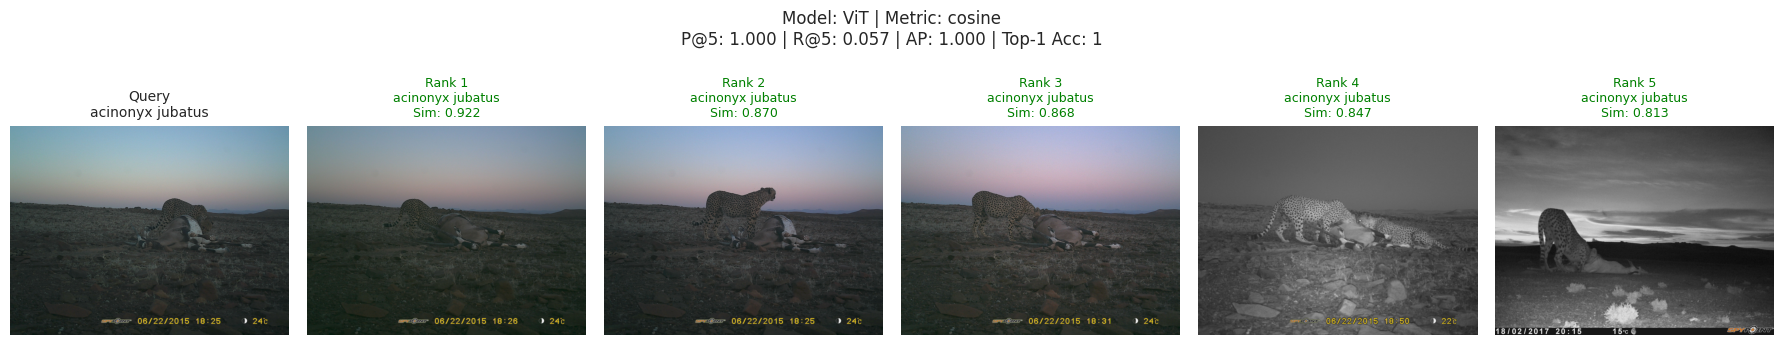

In [111]:
visualize_query_results_with_scores(
    query_idx=25,
    model_name="ViT",  # oder "ViT", "GoogLeNet"
    metric_name="cosine",
    df_test=df_test,
    model_outputs=model_outputs,
    top_k=5
)

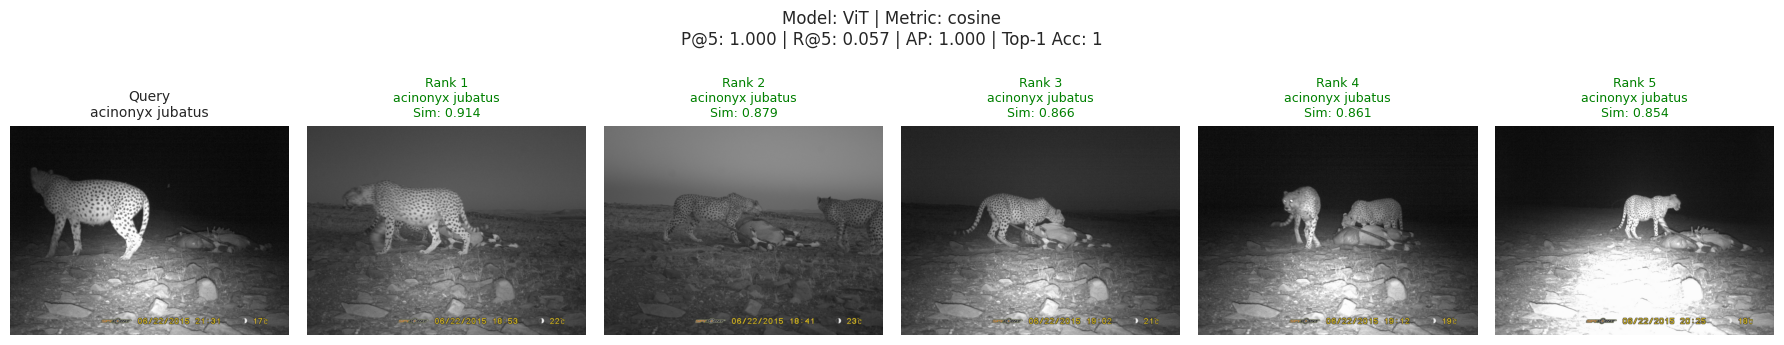

In [112]:
visualize_query_results_with_scores(
    query_idx=42,
    model_name="ViT",  # oder "ViT", "GoogLeNet"
    metric_name="cosine",
    df_test=df_test,
    model_outputs=model_outputs,
    top_k=5
)

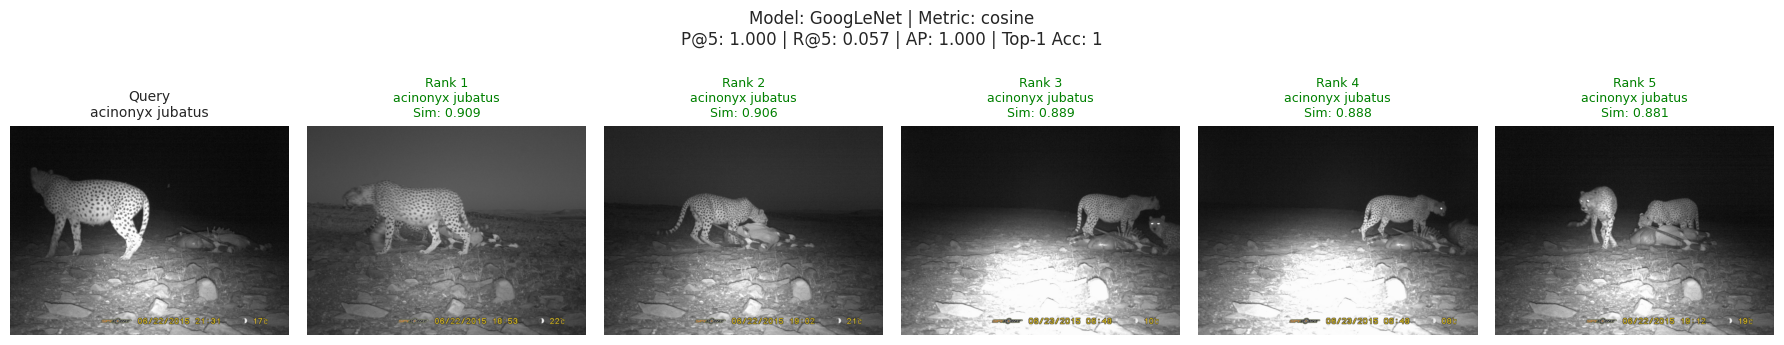

In [113]:
visualize_query_results_with_scores(
    query_idx=42,
    model_name="GoogLeNet",  # oder "ViT", "GoogLeNet"
    metric_name="cosine",
    df_test=df_test,
    model_outputs=model_outputs,
    top_k=5
)

In [ ]:
# Filtern guter und schlechter Beispiele

def get_extreme_queries(model_name, metric_name, detailed_csv_path, n=3):
    df = pd.read_csv(detailed_csv_path)

    # Best Cases (Precision@5 = 1.0)
    best_queries = df[df["Precision@5"] == 1.0].head(n).index.tolist()

    # Worst Cases (Precision@5 = 0.0)
    worst_queries = df[df["Precision@5"] == 0.0].head(n).index.tolist()

    print(f"🔹 {model_name} ({metric_name}) – Best Query IDs:", best_queries)
    print(f"🔻 {model_name} ({metric_name}) – Worst Query IDs:", worst_queries)

    return best_queries, worst_queries

In [21]:
best, worst = get_extreme_queries(
    model_name="ViT",
    metric_name="cosine",
    detailed_csv_path="cbir_detailed_ViT_bs64+augm+iNat_cosine.csv",
    n=3
)

🔹 ViT (cosine) – Best Query IDs: [0, 2, 3]
🔻 ViT (cosine) – Worst Query IDs: [23, 24, 33]


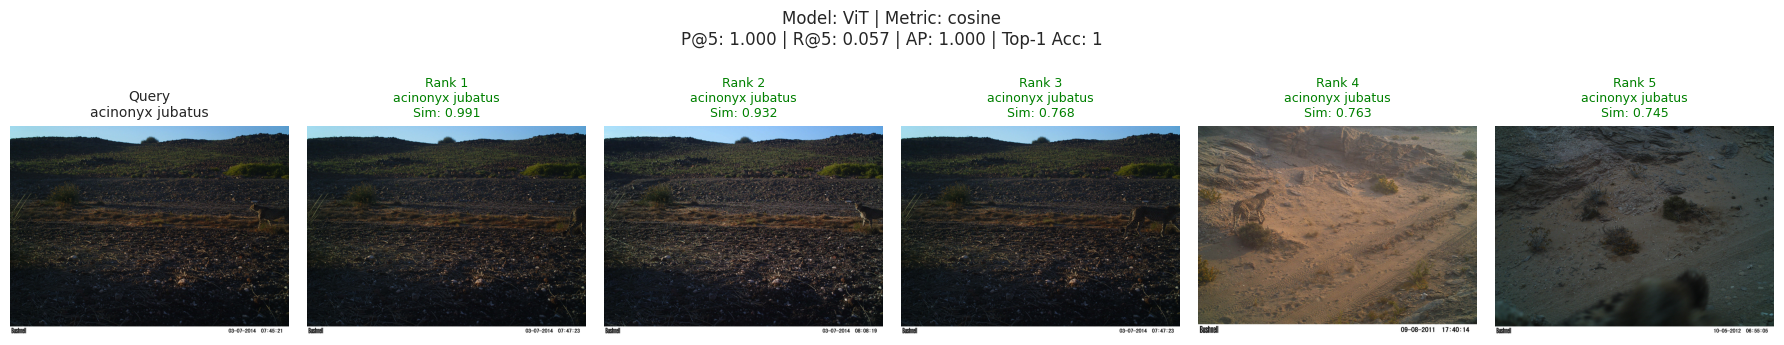

In [116]:
#  Best Case visualisieren
visualize_query_results_with_scores(
    query_idx=best[0],
    model_name="ViT",
    metric_name="cosine",
    df_test=df_test,
    model_outputs=model_outputs,
    top_k=5
)

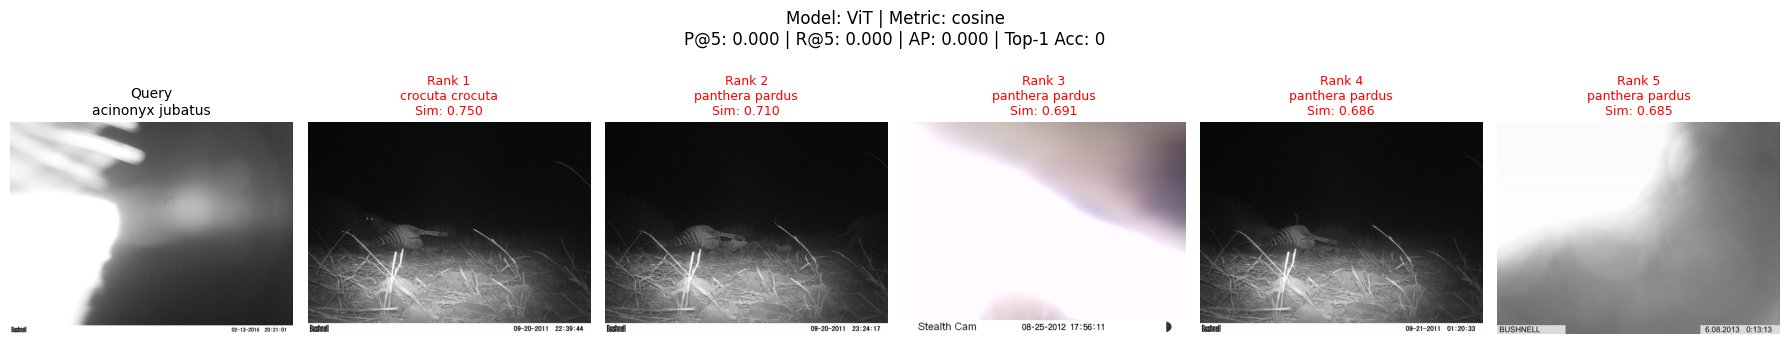

In [28]:
#  Worst Case visualisieren
visualize_query_results_with_scores(
    query_idx=worst[0],
    model_name="ViT",
    metric_name="cosine",
    df_test=df_test,
    model_outputs=model_outputs,
    top_k=5
)

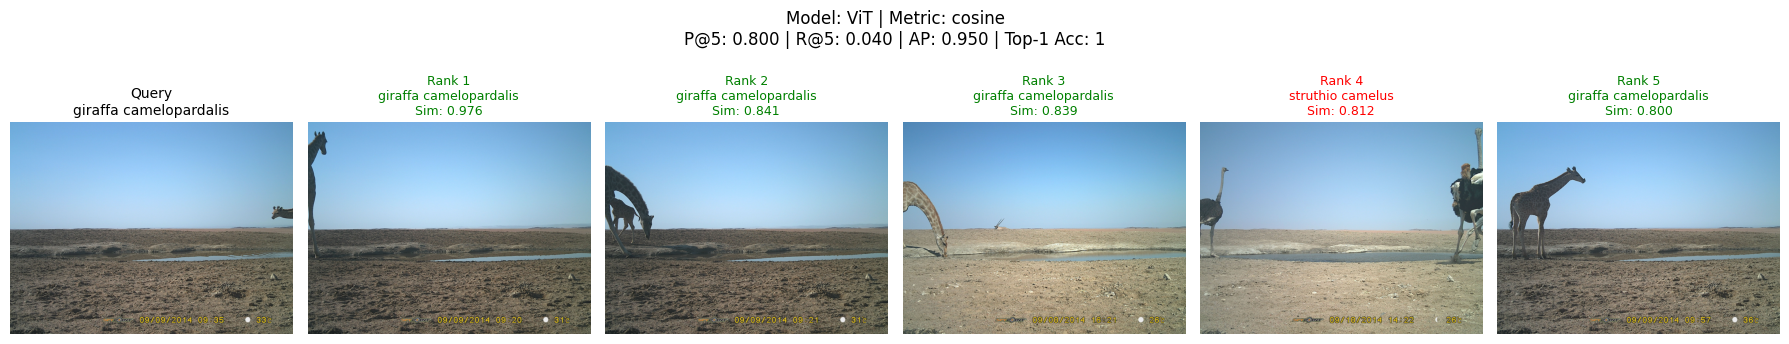

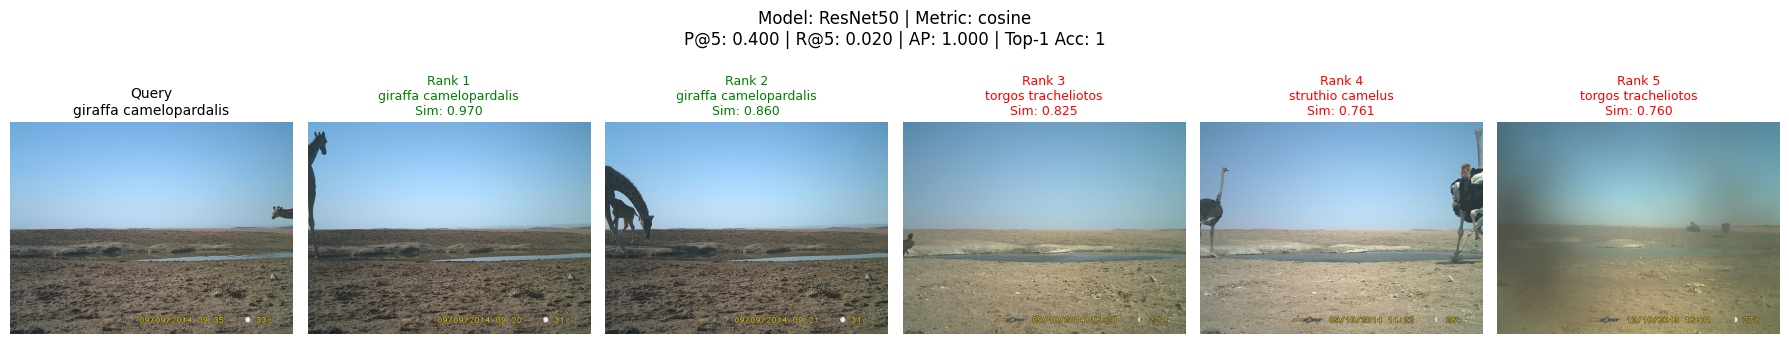

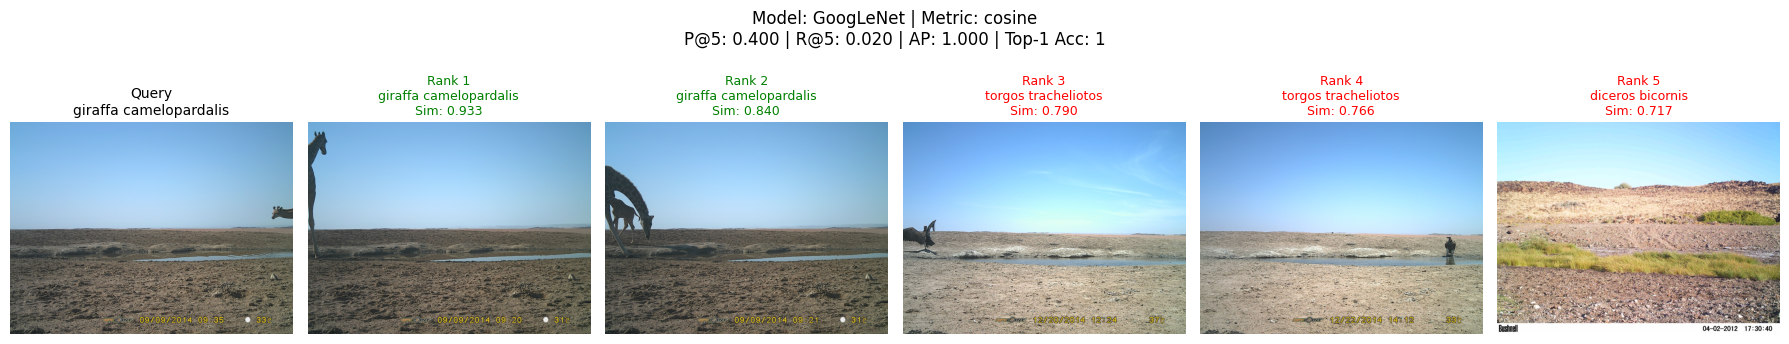

In [25]:
# --- Beispiel-ID für Modellvergleich ---
query_idx = 800
for model_name in ["ViT", "ResNet50", "GoogLeNet"]:
    visualize_query_results_with_scores(
        query_idx=query_idx,
        model_name=model_name,
        metric_name="cosine",
        df_test=df_test,
        model_outputs=model_outputs,
        #save_path=f"query{query_idx}_{model_name}.png"
    )


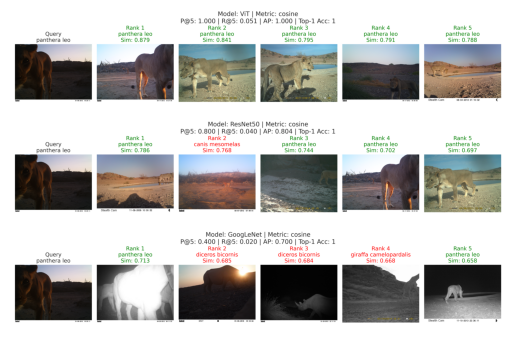

In [ ]:
# Beispiel: Query ID
query_idx = 1422

# Bildpfade 
filenames = [
    f"query{query_idx}_ViT.png",
    f"query{query_idx}_ResNet50.png",
    f"query{query_idx}_GoogLeNet.png"
]

# Bilder laden
images = [Image.open(f) for f in filenames]

# Breite = max aller Breiten, Höhe = Summe aller Höhen
width = max(img.width for img in images)
total_height = sum(img.height for img in images)

# Neues Bild mit weißem Hintergrund
combined_image = Image.new('RGB', (width, total_height), (255, 255, 255))

# Bilder einfügen
y_offset = 0
for img in images:
    combined_image.paste(img, (0, y_offset))
    y_offset += img.height

# Speichern
output_path = f"query{query_idx}_combined_vertical.png"
#combined_image.save(output_path)

# Anzeigen
plt.imshow(combined_image)
plt.axis("off")
#plt.title(f"Combined Query Result – ID {query_idx}")
plt.show()

In [ ]:
scale_factor = 2  
large_image = combined_image.resize(
    (combined_image.width * scale_factor, combined_image.height * scale_factor),
    resample=Image.BICUBIC
)
large_image.save(f"query{query_idx}_combined_vertical_large.png")


/tmp/ipykernel_3987685/2135661807.py:4: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resample=Image.BICUBIC


### Grad-CAM

In [54]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision import transforms

In [80]:
def generate_gradcam(model, img_path, target_layer, device, target_class_idx=None):
    # Bild laden und vorbereiten
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Grad-CAM initialisieren
    cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=None)
    
    targets = None
    if target_class_idx is not None:
        targets = [ClassifierOutputTarget(target_class_idx)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    
    # Overlay erzeugen
    rgb_img = np.array(img.resize((224, 224))) / 255.0
    if rgb_img.shape[-1] == 4:  # PNG transparency check
        rgb_img = rgb_img[..., :3]
    visualization = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)
    
    return visualization

In [81]:
def visualize_query_results_with_gradcam_and_originals(query_idx, model_name, metric_name, df_test, model_outputs, model, target_layer, top_k=5):
    """
    Zeigt Query + Top-K Ergebnisse: jeweils Originalbild und Grad-CAM Overlay
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.eval().to(device)

    features_array = model_outputs[model_name]["features"]
    labels_array = model_outputs[model_name]["labels"]

    query_path = df_test.iloc[query_idx]['file_path']
    query_feat = features_array[query_idx]
    query_label = labels_array[query_idx]

    top_indices, scores = search(query_feat, features_array, metric=metric_name, top_k=top_k + 1)
    top_indices = top_indices[1:]
    scores = scores[1:]
    retrieved_labels = labels_array[top_indices]

    fig, axes = plt.subplots(2, top_k + 1, figsize=(20, 6))

    # Query Original
    axes[0,0].imshow(Image.open(query_path))
    axes[0,0].set_title(f"Query Original\n{query_label}", fontsize=10)
    axes[0,0].axis('off')

    # Query Grad-CAM
    query_img_gradcam = generate_gradcam(model, query_path, target_layer, device)
    axes[1,0].imshow(query_img_gradcam)
    axes[1,0].set_title(f"Query Grad-CAM", fontsize=10)
    axes[1,0].axis('off')

    # Retrievals: Original und Grad-CAM
    for i, (idx, score) in enumerate(zip(top_indices, scores)):
        img_path = df_test.iloc[idx]['file_path']
        label = labels_array[idx]
        correct = (label == query_label)
        color = 'green' if correct else 'red'
        metric_label = f"{'Sim' if metric_name == 'cosine' else 'Dist'}: {score:.3f}"

        # Originalbild
        axes[0,i+1].imshow(Image.open(img_path))
        axes[0,i+1].set_title(f"Rank {i+1}\n{label}\n{metric_label}", fontsize=9, color=color)
        axes[0,i+1].axis('off')

        # Grad-CAM Overlay
        retrieved_img_gradcam = generate_gradcam(model, img_path, target_layer, device)
        axes[1,i+1].imshow(retrieved_img_gradcam)
        axes[1,i+1].set_title(f"Grad-CAM {i+1}", fontsize=9, color=color)
        axes[1,i+1].axis('off')

    plt.suptitle(f"Model: {model_name} | Metric: {metric_name}", fontsize=14)
    plt.tight_layout()
    plt.show()


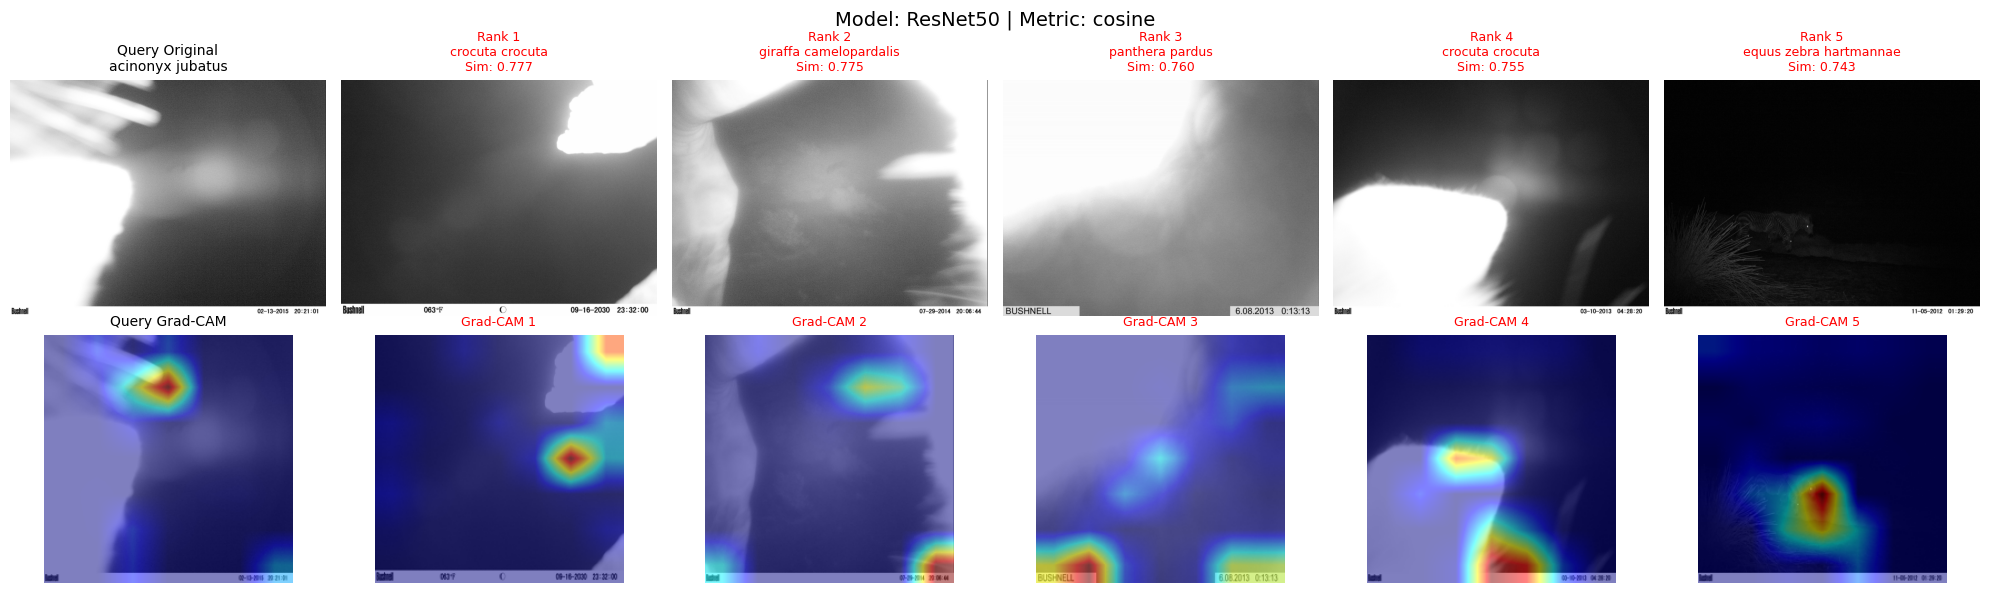

In [97]:
learn = load_learner('../basemodel_outputs/resnet50_bs16+aug+iNat.pkl')
model = learn.model

target_layer = model[0][-1]  # oder anpassen je nach Modellstruktur

visualize_query_results_with_gradcam_and_originals(
    query_idx=worst[0],
    model_name="ResNet50",
    metric_name="cosine",
    df_test=df_test,
    model_outputs=model_outputs,
    model=model,
    target_layer=target_layer,
    top_k=5
)

In [95]:
print(model[0][-1])

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

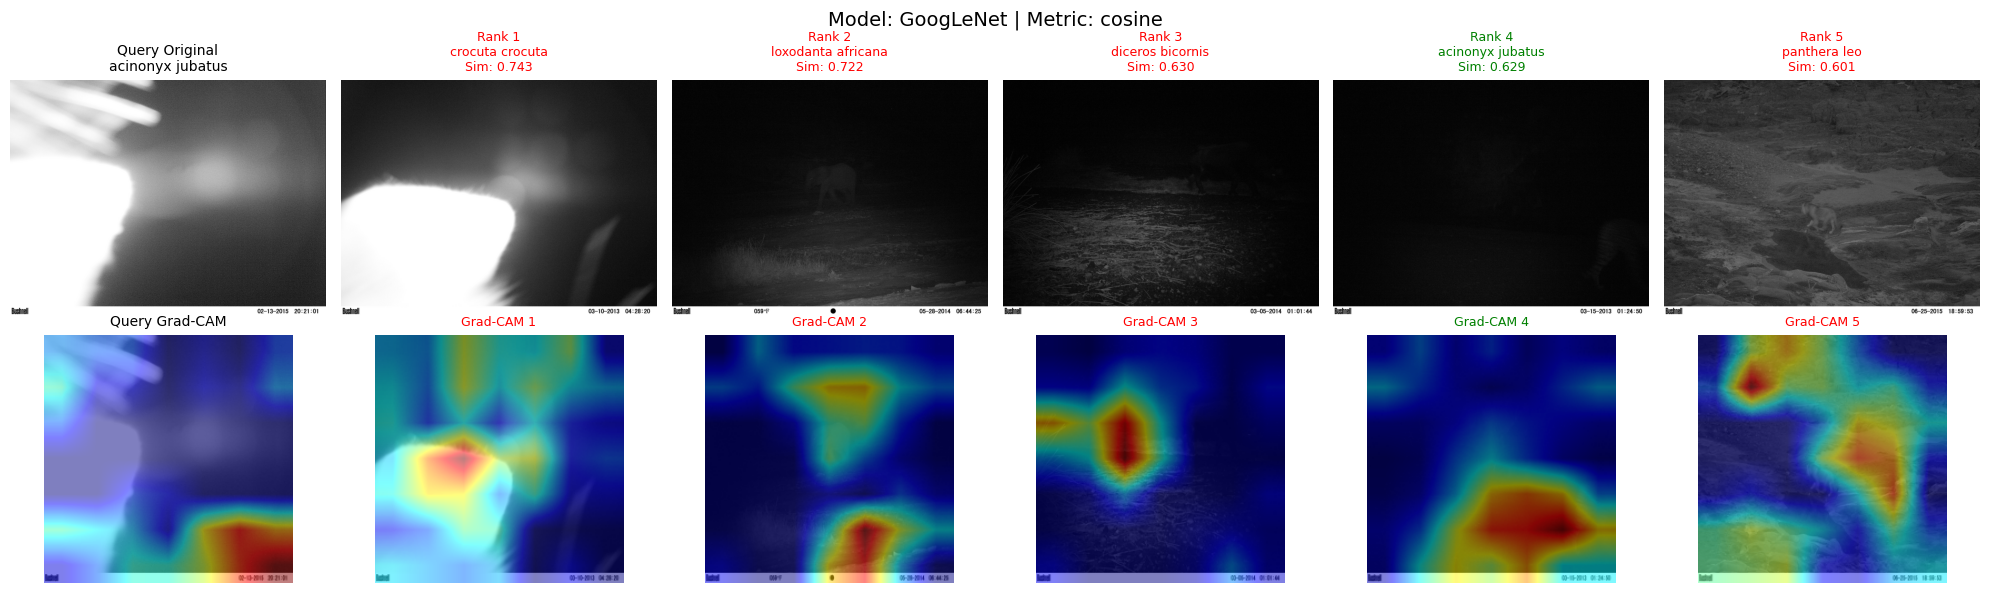

In [88]:
learn = load_learner('../basemodel_outputs/googlenet_bs128+aug.pkl')
model = learn.model

target_layer = model[0][-1]  # anpassen

visualize_query_results_with_gradcam_and_originals(
    query_idx=worst[0],
    model_name="GoogLeNet",
    metric_name="cosine",
    df_test=df_test,
    model_outputs=model_outputs,
    model=model,
    target_layer=target_layer,
    top_k=5
)

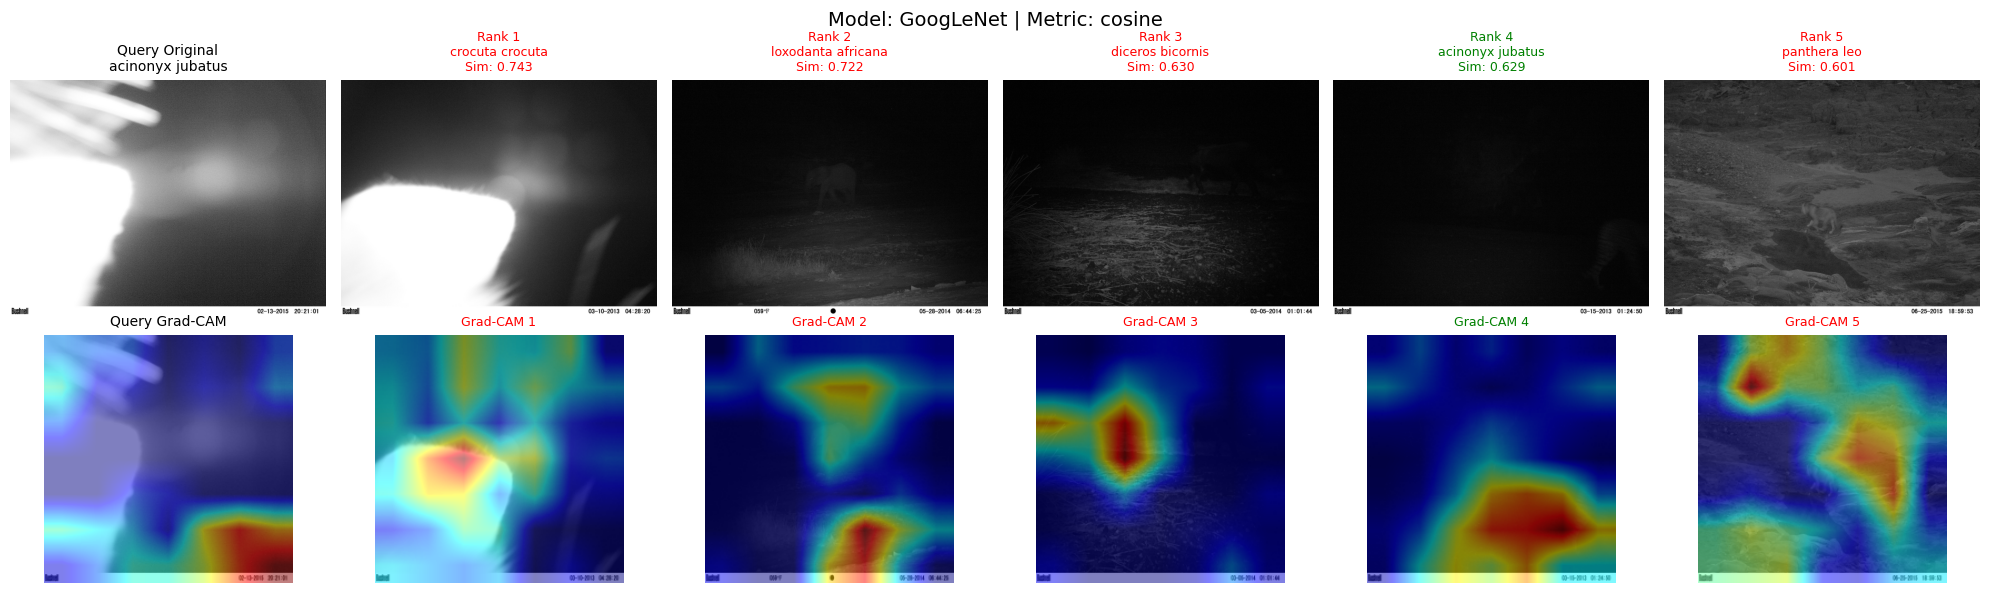

In [92]:
learn = load_learner('../basemodel_outputs/googlenet_bs128+aug.pkl')
model = learn.model

target_layer = model[0][-1]  # anpassen

visualize_query_results_with_gradcam_and_originals(
    query_idx=worst[0],
    model_name="GoogLeNet",
    metric_name="cosine",
    df_test=df_test,
    model_outputs=model_outputs,
    model=model,
    target_layer=target_layer,
    top_k=5
)